![nombreNotebook.JPG](img/nombreNotebook.JPG)  


# Tarea 2 - Regresion Polinomial & Feature engineering

### Parte 1 - Modelo exponencial de covid-19 usando feature-eng

Usando el ejemplo de covid-19 en el notebook de feature-eng (https://colab.research.google.com/drive/1sJV2HG7tQgCGKES3-dIclzHQJ9qAWB3b?usp=sharing) crear un modelo de covid-19 para Guatemala.

* Convertir la fecha a un entero "número de día", por ejemplo si se usan datos desde el 22 de abril, este es el día 0, el 23 es el día 1.
* Aplicar regresión lineal sobre la variable "Confirmed" transformada.
* Una vez entrenado el modelo usarlo para aproximar la cantidad de casos confirmados para el 30 de mayo. Se debe reportar la cantidad de casos, no la cantidad transformada obtenida.

------------ En proceso

### Parte 2 - Modelo polinomial de calidad de vinos

Es permitido utilizar [sklearn.preprocessing.polynomialfeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)


### Instrucciones

1. Seleccionar y transformar(generando las combinaciones polinomiales para un polinomio de grado dos o tres a elección) las features que considere que son las mejores para predecir la calidad del vino, utilizar como minimo 2 features. Para seleccionar las features, hacer un analisis exploratorio por ejemplo(pero no limitado a ):  graficando y viendo la forma en que se comportan los datos.

 Por ejemplo, se tienen las features "a" y "b" y seleccionamos polinomio de grado 2, hacemos feature engineering para obtener :
 
 $[a,b,a^{2},b^{2},ab]$
 
 No olvidar el "bias" (parámetro multiplicado por 1) ,con lo cual el dataset puede quedar con las columnas:
 
 $[1,a,b,a^{2},b^{2},ab]$
2. Una vez transformada la data aplicar regresion lineal con las features polinomiales usando Tensorflow.

Requisitos adicionales:
* Se debe agregar al notebook un screenshot del grafo de tensorboard, simplificando(usando  names , y name_scope como visto en clase).

* Se debe generar un directorio de logs de tensorboard para cada corrida/experimento , con cada directorio identificando facilmente la configuración del experimento como visto en clase, por ejemplo para un experimento con learning rate = 0.1 , y polinomio grado 2  crear un directorio: lr=0.1_polinomio_grado=2. (Agregar al notebook un screenshot de estas gráficas)

* Concluir en markdown cual es el mejor modelo para este caso basado en la comparativa entre curvas de costo/error en tensorboard.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb 
import matplotlib.pyplot as plt

In [2]:
dfVinos = pd.read_csv('winequality-red.csv')

Para efectos prácticos se considera utilizar la versión 1 de tensorFlow, por lo cual se desactiva la versión 2 que es la actual

In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

W0613 01:01:14.101024 10256 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\compat\v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


### Red Wine Quality Data

Se aplicará regresión para crear un modelo de la calidad de vino en función de características del mismo, siendo 1 el peor vino y 10 el mejor.

Variables de entrada:
1. fixed acidity 
2. volatile acidity 
3. citric acid 
4. residual sugar 
5. chlorides 
6. free sulfur dioxide 
7. total sulfur dioxide 
8. density 
9. pH 
10. sulphates 
11. alcohol 

Varaible a predecir: 
12. quality (puntuacion  entre 0 y 10) 



## Analisis exploratorio
Cantidad de variables y observaciones.  


In [4]:
print("Data Frame de Entrenamiento:   ",dfVinos.shape)

Data Frame de Entrenamiento:    (1599, 12)


In [5]:
dfVinos.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

**Nota:**  
Se tienen 1599 observaciones y 12 variables a analizar.  
**Observar que la columna 11 es la calidad de vino, la cual se utilizará como variable dependiente Y**

Ejemplo del contenido del dataset

In [6]:
dfVinos.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

 Valores estadísticos

In [7]:
dfVinos.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             22.000000     0.995600   
50%       0.079000            14.000000             38.000000     0.996750   
75%       0.090000            21.000000             62.000000     0.997835   
max       0.611000            72.000000            289.000000     1.003690   

                pH    sulphates      alcohol      quality  
count  1599.000000  1599.000000  1599.000000  1599.000000  
mean      3.311113     0.658149    10.422983     5.636023  
std       0.154386     0.169507     1.065668     0.807569  
min       2.740000     0.330000     8.400000     3.000000  
25%       3.210000     0.550000     9.500000     5.000000  
50%       3.310000     0.620000    10.200000     6.000000  
75%       3.400000     0.730000    11.100000     6.000000  
max       4.010000     2.000000    14.900000     8.000000

Analizando correlación:

In [8]:
dfVinos.corr()

fixed acidity  volatile acidity  citric acid  \
fixed acidity              1.000000         -0.256131     0.671703   
volatile acidity          -0.256131          1.000000    -0.552496   
citric acid                0.671703         -0.552496     1.000000   
residual sugar             0.114777          0.001918     0.143577   
chlorides                  0.093705          0.061298     0.203823   
free sulfur dioxide       -0.153794         -0.010504    -0.060978   
total sulfur dioxide      -0.113181          0.076470     0.035533   
density                    0.668047          0.022026     0.364947   
pH                        -0.682978          0.234937    -0.541904   
sulphates                  0.183006         -0.260987     0.312770   
alcohol                   -0.061668         -0.202288     0.109903   
quality                    0.124052         -0.390558     0.226373   

                      residual sugar  chlorides  free sulfur dioxide  \
fixed acidity               0.114777   0.093705            -0.153794   
volatile acidity            0.001918   0.061298            -0.010504   
citric acid                 0.143577   0.203823            -0.060978   
residual sugar              1.000000   0.055610             0.187049   
chlorides                   0.055610   1.000000             0.005562   
free sulfur dioxide         0.187049   0.005562             1.000000   
total sulfur dioxide        0.203028   0.047400             0.667666   
density                     0.355283   0.200632            -0.021946   
pH                         -0.085652  -0.265026             0.070377   
sulphates                   0.005527   0.371260             0.051658   
alcohol                     0.042075  -0.221141            -0.069408   
quality                     0.013732  -0.128907            -0.050656   

                      total sulfur dioxide   density        pH  sulphates  \
fixed acidity                    -0.113181  0.668047 -0.682978   0.183006   
volatile acidity                  0.076470  0.022026  0.234937  -0.260987   
citric acid                       0.035533  0.364947 -0.541904   0.312770   
residual sugar                    0.203028  0.355283 -0.085652   0.005527   
chlorides                         0.047400  0.200632 -0.265026   0.371260   
free sulfur dioxide               0.667666 -0.021946  0.070377   0.051658   
total sulfur dioxide              1.000000  0.071269 -0.066495   0.042947   
density                           0.071269  1.000000 -0.341699   0.148506   
pH                               -0.066495 -0.341699  1.000000  -0.196648   
sulphates                         0.042947  0.148506 -0.196648   1.000000   
alcohol                          -0.205654 -0.496180  0.205633   0.093595   
quality                          -0.185100 -0.174919 -0.057731   0.251397   

                       alcohol   quality  
fixed acidity        -0.061668  0.124052  
volatile acidity     -0.202288 -0.390558  
citric acid           0.109903  0.226373  
residual sugar        0.042075  0.013732  
chlorides            -0.221141 -0.128907  
free sulfur dioxide  -0.069408 -0.050656  
total sulfur dioxide -0.205654 -0.185100  
density              -0.496180 -0.174919  
pH                    0.205633 -0.057731  
sulphates             0.093595  0.251397  
alcohol               1.000000  0.476166  
quality               0.476166  1.000000

Se ordenan los valores de la columna **"quality"** para identificar las filas que tienen mayor correlación tanto positiva como negativa.  

In [9]:
dfVinos.corr()["quality"].sort_values(ascending=False)

quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64

Por lo tanto, se tomarán las variables **"alcohol"** y **"volatile acidity"**.

In [10]:
calidad=dfVinos["quality"]
calidad.head()


0    5
1    5
2    5
3    6
4    5
Name: quality, dtype: int64

In [11]:
for num, line in enumerate(dfVinos.columns):
    print("Indice: " ,num, "\t Variable: ", line)

Indice:  0 	 Variable:  fixed acidity
Indice:  1 	 Variable:  volatile acidity
Indice:  2 	 Variable:  citric acid
Indice:  3 	 Variable:  residual sugar
Indice:  4 	 Variable:  chlorides
Indice:  5 	 Variable:  free sulfur dioxide
Indice:  6 	 Variable:  total sulfur dioxide
Indice:  7 	 Variable:  density
Indice:  8 	 Variable:  pH
Indice:  9 	 Variable:  sulphates
Indice:  10 	 Variable:  alcohol
Indice:  11 	 Variable:  quality


Histogramas

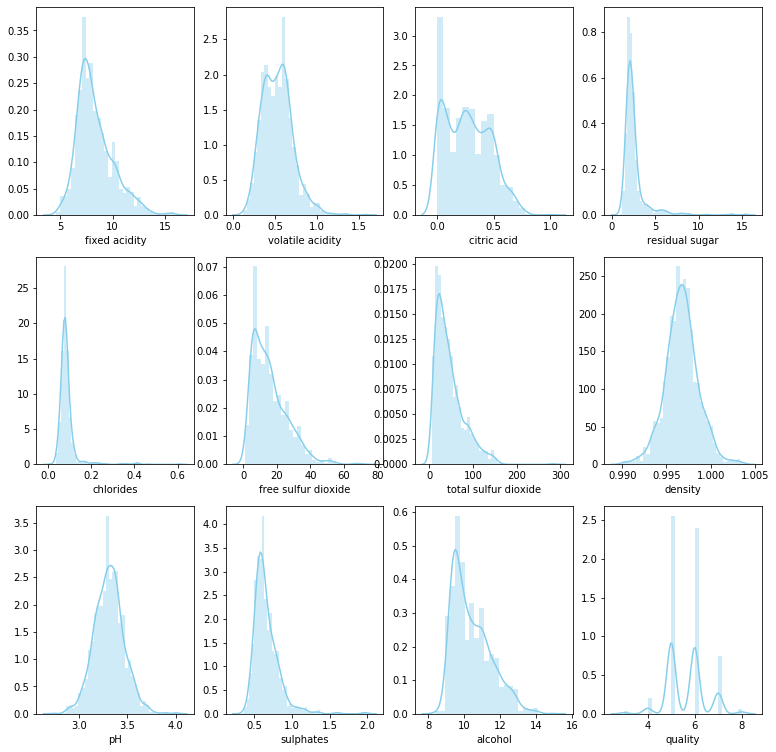

In [12]:
## Se define subplot
filasTabla=3
columnasTabla=4
fig, axes = plt.subplots(filasTabla,columnasTabla, figsize=(13, 13), sharex=False)

indice=0
for i in range(filasTabla):
        
    for j in range(columnasTabla):
        sb.distplot(dfVinos.iloc[0:,indice],color="skyblue", ax=axes[i, j])
        indice+=1

## Aplicando regresión polinomial

Ya que se han seleccionado las dos variables "Alcohol" y "Acidez volátil", se procede llevarlo a la forma:  
 * a = Alcohol
 * b = AcidezVolatil

$[1,a,b,a^{2},b^{2},ab]$

In [13]:
a=dfVinos["alcohol"]
b=dfVinos["volatile acidity"]
aa=a*a
bb=b*b
ab=a*b

In [14]:
##Creando matriz
matrizPolinomial=pd.concat([a, b,aa,bb,ab], axis=1)
matrizPolinomial.insert(0, 'unos', 1)
matrizPolinomial.columns=["unos","a","b","aa","bb","ab"]

matrizPolinomial.head()

unos    a     b     aa      bb     ab
0     1  9.4  0.70  88.36  0.4900  6.580
1     1  9.8  0.88  96.04  0.7744  8.624
2     1  9.8  0.76  96.04  0.5776  7.448
3     1  9.8  0.28  96.04  0.0784  2.744
4     1  9.4  0.70  88.36  0.4900  6.580

Dado que nuestra matriz es de 6 columnas, se requiereon 6 parametros entrenables.

In [15]:
matrizPolinomial.shape[1]

6

Definicion de parametros en forma matricial

In [16]:
parametros=pd.DataFrame([0.0,0,0,0,0,0],columns=["parametros"])
parametros

parametros
0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
5         0.0

### Definición del grafo

In [17]:
grafo = tf.Graph()
with grafo.as_default():
    
    #placeholder para el Learning Rate
    tensorLR = tf.placeholder(dtype = tf.float64,name = "LR")    
  
    # Asignación de constantes para las variables independientes y dependiente
    tensorCalidad = tf.constant(calidad,tf.float64)
    tensorMatrizPolinomial = tf.constant(matrizPolinomial)
    
    # Parametros entrenables del modelo 
    tensorParametros = tf.Variable(parametros, name = "Parametros", dtype = tf.float64)
    
    with tf.name_scope("Modelo"):
        # producto matricial para creación del modelo basado en regresión lineal 
        tensorCalidadHat = tf.matmul(tensorMatrizPolinomial, tensorParametros)
        
    with tf.name_scope("Funcion_Costo"):
        # función costo
        tensorError = (tf.reduce_mean(tf.pow(tensorCalidad-tensorCalidadHat,2)))*0.5
    
    
    # código para tensorboard
    # función de costo en tensorboard
    with tf.name_scope("Resumen"):
        tensorSummary = tf.summary.scalar(name='Resumen', tensor=tensorError)
    
    with tf.name_scope("Optimizador"):
        # grafica del tensor optimizador utilizando GD desde TF
        tensorOptimizador = tf.train.GradientDescentOptimizer(tensorLR).minimize(tensorError)
    
    #Para efectos visuales de impresión se pasan los parametros a forma lineal
    #Esto es únicamente para la impresión, no para el calculo del modelo. 
    tensorParametrosLinea= tf.reshape(tensorParametros, [6])
    
    #init = tf.global_variables_initializer()

### Funcion para entrenar el modelo

In [18]:
def entrenar(epocas,learningRate,imprime,grafoEntrada,parametrosEntrada):
    
    with tf.Session(graph = grafoEntrada) as session:
        
        # inicializacion de variables con funcion de TF
        tf.global_variables_initializer().run()
        
        
        print('....:::::::::Inicio del proceso de Entrenamiento:::::::::....\n')
        
        ## Escritura de logs para TensorBoard en el directorio logs/parametrosX
        ## Notar que se usa lenght parametros para identificar el modelo que tiene 6 parametros entrenables
        
        # TENSORBOARD INICIO
        writer = tf.summary.FileWriter('./logs/parametros.%d_lr.%f' % (len(parametrosEntrada), learningRate), session.graph)
        # TENSORBOARD FIN
        
        for contador in range(epocas): 
            # envío de parametros por medio de feed_dict.
            # Se ejecutan las instrucciones del grafo definido anteriormente con tensorError y tensorOptimizador
            
            error = session.run(tensorError)
            optimizador = session.run(tensorOptimizador,feed_dict={tensorLR:learningRate})
            summary = session.run(tensorSummary)
            parametrosEnlinea= session.run(tensorParametrosLinea)
       
        # TENSORBOARD INICIO
            writer.add_summary(summary, contador)
        # TENSORBOARD FIN
        
            if (contador % imprime == 0):            
                print("Iteracion:", contador, "Error:", error, "Parámetros:",  parametrosEnlinea)  
       
        # TENSORBOARD INICIO
        writer.close()
        # TENSORBOARD FIN


## Entrenamiento del modelo
Se modifica el valor del Learning rate de:  

* LR = 0.0001  
* LR = 0.001  
* LR = 0.01  
* LR = 0.1  
* LR = 1  
* LR = 10  
* LR = 100  

In [19]:
entrenar(10,0.0001,1,grafo,parametros)

....:::::::::Inicio del proceso de Entrenamiento:::::::::....

Iteracion: 0 Error: 16.20825515947467 Parámetros: [0.0005636  0.00587442 0.00029748 0.0618686  0.00017508 0.0030789 ]
Iteracion: 1 Error: 2.1296040124945685 Parámetros: [0.00044017 0.00443435 0.00023745 0.04496632 0.00014168 0.00238212]
Iteracion: 2 Error: 1.0813251913379882 Parámetros: [0.00050418 0.00498989 0.00027496 0.04955549 0.00016515 0.0027154 ]
Iteracion: 3 Error: 1.0030125634984681 Parámetros: [0.00051704 0.00500093 0.00028584 0.04828105 0.0001731  0.00276756]
Iteracion: 4 Error: 0.9969033188132608 Parámetros: [0.00054384 0.00516048 0.00030398 0.04860641 0.00018527 0.00289634]
Iteracion: 5 Error: 0.9961690224341968 Parámetros: [0.00056684 0.00527948 0.00032013 0.0484953  0.00019628 0.00300413]
Iteracion: 6 Error: 0.9958350420707311 Parámetros: [0.00059087 0.00540951 0.00033681 0.04850328 0.0002076  0.00311756]
Iteracion: 7 Error: 0.9955310716037216 Parámetros: [0.00061461 0.0055365  0.00035334 0.04847878 0.0002188

In [20]:
entrenar(10,0.001,1,grafo,parametros)

....:::::::::Inicio del proceso de Entrenamiento:::::::::....

Iteracion: 0 Error: 16.20825515947467 Parámetros: [0.00563602 0.05874417 0.00297481 0.618686   0.00175076 0.03078896]
Iteracion: 1 Error: 2093.2770606371414 Parámetros: [-0.05743153 -0.61396002 -0.02980124 -6.63971607 -0.01734586 -0.31598913]
Iteracion: 2 Error: 287803.1405019104 Parámetros: [ 0.68527352  7.2919803   0.35671171 78.48712311  0.20805391  3.76538792]
Iteracion: 3 Error: 39588383.21976176 Parámetros: [  -8.02241004  -85.4154481    -4.17435232 -919.91233327   -2.43409407
  -44.08826401]
Iteracion: 4 Error: 5445546581.407973 Parámetros: [   94.1073504   1001.90573641    48.9696306  10789.66219157
    28.55534848   517.17012001]
Iteracion: 5 Error: 749057574175.8208 Parámetros: [  -1103.7030631   -11750.55989538    -574.31944458 -126544.31051154
    -334.89823112   -6065.44979426]
Iteracion: 6 Error: 103035983834185.88 Parámetros: [  12944.63787061  137814.81700783    6735.83409476 1484156.37630756
    3927.813396

In [21]:
entrenar(10,0.01,1,grafo,parametros)

....:::::::::Inicio del proceso de Entrenamiento:::::::::....

Iteracion: 0 Error: 16.20825515947467 Parámetros: [0.05636023 0.58744167 0.02974808 6.18685997 0.01750756 0.30788961]
Iteracion: 1 Error: 242572.4280046829 Parámetros: [  -6.75763678  -71.96995204   -3.5155897  -775.33508624   -2.04972239
  -37.14092585]
Iteracion: 2 Error: 3868412851.8944664 Parámetros: [  854.03417702  9092.42067722   444.40384409 97917.76346487
   259.14207961  4693.37574675]
Iteracion: 3 Error: 61691585564645.74 Parámetros: [  -107849.46574962  -1148217.20858507    -56120.23038358
 -12365390.8492324     -32724.94249657   -592691.48315157]
Iteracion: 4 Error: 9.838277030181083e+17 Parámetros: [1.36196076e+07 1.45000877e+08 7.08705908e+06 1.56154465e+09
 4.13262032e+06 7.48471514e+07]
Iteracion: 5 Error: 1.5689610509550522e+22 Parámetros: [-1.71993151e+09 -1.83112161e+10 -8.94978516e+08 -1.97197300e+11
 -5.21881694e+08 -9.45195910e+09]
Iteracion: 6 Error: 2.5021035409577967e+26 Parámetros: [2.17198944e+11

In [22]:
entrenar(10,0.1,1,grafo,parametros)

....:::::::::Inicio del proceso de Entrenamiento:::::::::....

Iteracion: 0 Error: 16.20825515947467 Parámetros: [ 0.56360225  5.87441675  0.29748083 61.86859973  0.17507561  3.0788961 ]
Iteracion: 1 Error: 24604131.575225085 Parámetros: [  -685.90851804  -7302.73470562   -356.91362493 -78647.14341902
   -208.12359973  -3769.51271493]
Iteracion: 2 Error: 39798753288154.0 Parámetros: [8.72416752e+05 9.28816703e+06 4.53968224e+05 1.00026202e+08
 2.64718873e+05 4.79440442e+06]
Iteracion: 3 Error: 6.437702573864454e+19 Parámetros: [-1.10956995e+09 -1.18130141e+10 -5.77372567e+08 -1.27216810e+11
 -3.36678667e+08 -6.09769039e+09]
Iteracion: 4 Error: 1.0413395145690984e+26 Parámetros: [1.41118973e+12 1.50242030e+13 7.34322551e+11 1.61798772e+14
 4.28199661e+11 7.75525512e+12]
Iteracion: 5 Error: 1.684433184293668e+32 Parámetros: [-1.79480028e+15 -1.91083049e+16 -9.33937010e+14 -2.05781316e+17
 -5.44599250e+14 -9.86340371e+15]
Iteracion: 6 Error: 2.7246782751001007e+38 Parámetros: [2.28268954e

In [23]:
entrenar(10,1,1,grafo,parametros)

....:::::::::Inicio del proceso de Entrenamiento:::::::::....

Iteracion: 0 Error: 16.20825515947467 Parámetros: [  5.63602251  58.7441675    2.97480829 618.68599734   1.75075611
  30.78896095]
Iteracion: 1 Error: 2463896486.8254223 Parámetros: [  -68692.30020877  -731330.8655769    -35744.90904258 -7875850.68985463
   -20843.87358305  -377505.47278987]
Iteracion: 2 Error: 3.9911525528135904e+17 Parámetros: [8.74270074e+08 9.30789869e+09 4.54932614e+08 1.00238700e+11
 2.65281233e+08 4.80458958e+09]
Iteracion: 3 Error: 6.4650843933057655e+25 Parámetros: [-1.11271399e+13 -1.18464870e+14 -5.79008588e+12 -1.27577286e+15
 -3.37632667e+12 -6.11496857e+13]
Iteracion: 4 Error: 1.0472492759792035e+34 Parámetros: [1.41618987e+17 1.50774368e+18 7.36924407e+16 1.62372058e+19
 4.29716861e+16 7.78273359e+17]
Iteracion: 5 Error: 1.696390919776029e+42 Parámetros: [-1.80243419e+21 -1.91895793e+22 -9.37909373e+20 -2.06656577e+23
 -5.46915623e+20 -9.90535625e+21]
Iteracion: 6 Error: 2.747905602520288e+50

In [24]:
entrenar(10,10,1,grafo,parametros)

....:::::::::Inicio del proceso de Entrenamiento:::::::::....

Iteracion: 0 Error: 16.20825515947467 Parámetros: [  56.36022514  587.44167497   29.74808294 6186.85997342   17.50756111
  307.88960951]
Iteracion: 1 Error: 246424496417.1267 Parámetros: [-6.87024450e+06 -7.31436605e+07 -3.57502637e+06 -7.87696432e+08
 -2.08470249e+06 -3.77560893e+07]
Iteracion: 2 Error: 3.9922815918537074e+21 Parámetros: [8.74455557e+11 9.30987343e+12 4.55029132e+11 1.00259966e+14
 2.65337515e+11 4.80560892e+12]
Iteracion: 3 Error: 6.467827904901301e+31 Parámetros: [-1.11302876e+17 -1.18498382e+18 -5.79172382e+16 -1.27613376e+19
 -3.37728178e+16 -6.11669841e+17]
Iteracion: 4 Error: 1.0478418629783025e+42 Parámetros: [1.41669066e+22 1.50827685e+23 7.37184998e+21 1.62429476e+24
 4.29868817e+21 7.78548571e+22]
Iteracion: 5 Error: 1.6975908851529646e+52 Parámetros: [-1.80319907e+27 -1.91977225e+28 -9.38307383e+26 -2.06744273e+29
 -5.47147711e+26 -9.90955967e+27]
Iteracion: 6 Error: 2.7502382899299184e+62 Parám

In [25]:
entrenar(10,100,1,grafo,parametros)

....:::::::::Inicio del proceso de Entrenamiento:::::::::....

Iteracion: 0 Error: 16.20825515947467 Parámetros: [  563.60225141  5874.41674968   297.48082936 61868.5997342
   175.07561106  3078.89609512]
Iteracion: 1 Error: 24642798133500.08 Parámetros: [-6.87034595e+08 -7.31447179e+09 -3.57507992e+08 -7.87707569e+10
 -2.08473401e+08 -3.77566435e+09]
Iteracion: 2 Error: 3.992394508931019e+25 Parámetros: [8.74474107e+14 9.31007091e+15 4.55038785e+14 1.00262093e+17
 2.65343144e+14 4.80571087e+15]
Iteracion: 3 Error: 6.468102309413176e+37 Parámetros: [-1.11306024e+21 -1.18501734e+22 -5.79188763e+20 -1.27616986e+23
 -3.37737730e+20 -6.11687141e+21]
Iteracion: 4 Error: 1.047901137812102e+50 Parámetros: [1.41674075e+27 1.50833018e+28 7.37211061e+26 1.62435219e+29
 4.29884015e+26 7.78576097e+27]
Iteracion: 5 Error: 1.6977109236967617e+62 Parámetros: [-1.80327558e+33 -1.91985370e+34 -9.38347191e+32 -2.06753044e+35
 -5.47170924e+32 -9.90998009e+33]
Iteracion: 6 Error: 2.750471658478266e+74 Par

## Sección TensorBoard

Instrucción en la línea de comandos para ver las graficas de los logs generados.  

Log individal:  
    
**tensorboard --logdir logs/parametros.6_lr.0.000100 --port 6006**  
**tensorboard --logdir logs/parametros.6_lr.0.001000 --port 6006**  
**tensorboard --logdir logs/parametros.6_lr.0.010000 --port 6006**  
**tensorboard --logdir logs/parametros.6_lr.0.100000 --port 6006**  
**tensorboard --logdir logs/parametros.6_lr.1.000000 --port 6006**  
**tensorboard --logdir logs/parametros.6_lr.10.000000 --port 6006**  
**tensorboard --logdir logs/parametros.6_lr.100.000000 --port 6006**  

  


Todos los logs  
**tensorboard --logdir logs --port 6006**  


Acceso:  
http://localhost:6006/


Archivos y directorios logs generados  
Carpetas generadas por LR  
![1.directorios.JPG](img/1.directorios.JPG)  

Archivo de eventos:  
![2.eventos.JPG](img/2.eventos.JPG)  

Board1:  
![3.board1.JPG](img/3.board1.JPG)  

Board2:  
![3.board2.JPG](img/3.board2.JPG)   

Grafo:  
![4.grafo.JPG](img/4.grafo.JPG)   










# Conclusión

Se observa que al utilizar un modelo **polinomial de grado 2**, el modelo es resuelto a partir de la **iteración número 4** con un learning rate de **0.0001**.    

Para los demás casos del LR, se observa inestabilidad en el error o la función costo no converge. En la mayoría de veces tiende a crecer e incluso, se observa que con un learning rate mayor a 0.01 el error es inestable al crecer y decrecer constantemente, es decir, no converge nunca.   


El modelo matemático recomendado para resolver este problema cuando se utilizan las 2 variables "alcohol" y "acidez volatil" es:  

Parametros:  [0.00054384 0.00516048 0.00030398 0.04860641 0.00018527 0.00289634]   

Formula:  
$CalidadDelVino = 0.00054384 + 0.00516048(a) + 0.00030398(b) + 0.04860641(ab)+ 0.00018527(a^2)+ 0.00289634(b^2)$   

*Donde:  
a= alcohol  
b= acidez volatil*



